# YOLO Training Evaluation
* In this notebook we are going to focus on fixing the training and post processing in consistencies to make sure the model is trained using the correct YOLO approach. 
* The model performance and evaluations will be compared to previous models that we trained in `07_final_training_evaluation.ipynb` but the custom model class, loss functions and post processing is different.

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.patches as patches



## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-12-02 10:13:24.652679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764699204.740432    3945 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764699204.766574    3945 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764699204.962313    3945 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764699204.962374    3945 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764699204.962376    3945 computation_placer.cc:177] computation placer alr

Num GPUs Available:  1


## Constants

In [2]:
data_dir = Path("..","data")
models_dir = Path("..","models")

model_names = []

## Import Scripts

In [2]:
import os
import sys
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import graph_compatible_data_generator,yolo_object_detection_model,training_utils,evaluation_utils

## logic to auto reload scripts without restarting the kernel
%load_ext autoreload
%autoreload 2

2025-12-02 11:44:46.796789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764704686.893332   20404 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764704686.921018   20404 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764704687.300463   20404 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764704687.300527   20404 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764704687.300528   20404 computation_placer.cc:177] computation placer alr

--- Loading and caching MNIST data... ---


2025-12-02 11:45:04.101746: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/sequential_1/random_zoom_1/Add_1/ReadVariableOp/_28}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-12-02 11:45:04.101823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13238743098698420684
2025-12-02 11:45:04.101856: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17668434652922163664
2025-12-02 11:45:04.101864: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/sequential_1/random_zoom_1/Add_1/ReadVariableOp/_28}}]]
	 [[StatefulPartitionedCall/StatefulPartitionedCall/sequential_1/random_rotation_1/Add/ReadVariableOp/_1

## Initialize Pipeline

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
# X_tensor = tf.reshape(X_tensor, shape=(-1, 28, 28, 1))
y_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

batch_size = 32
raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

# create a generator for 2 digits
data_gen_2_digits = graph_compatible_data_generator.create_data_generator(2)

processed_dataset_2 = raw_dataset.map(
    data_gen_2_digits).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

## Experiments

### YOLO Experiment 1

In [ ]:
checkpoint_filepath = '../models/yolo_experiment_1_digits_2_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)

# updating bbox lambda to 11
lambdas = {'bbox': 1.0, "bbox_coords": 1.0, "bbox_size": 1.0, 'class': 1.0,
           'obj': 1.0, 'obj_less': 1.0}

model = training_utils.get_fresh_base_model(batch_size=batch_size)
custom_model = yolo_object_detection_model.YoloObjectDetectionModel(
    model, lambdas=lambdas)

custom_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, clipnorm=1.0))

custom_model.build(input_shape=(None, 100, 100, 1))
# Fit the model
epochs = 20

# commenting out to avoid accidental fits and overwrites.
# history = custom_model.fit(
#     processed_dataset_2,
#     epochs=epochs,
#     callbacks=[model_checkpoint_callback]
# )

Epoch 1/20


I0000 00:00:1762552663.609542  833903 service.cc:152] XLA service 0x564eb55e6f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762552663.609597  833903 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-11-07 13:57:43.784545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762552664.723248  833903 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-07 13:57:45.874129: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[32,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,50,50]{3,2,1,0} %bitcast.10877, f32[8,8,3,3]{3,2,1,0} %bitcast.8371, f32[8]{0} %bitcast.10971), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

   3/1875 ━━━━━━━━━━━━━━━━━━━━ 1:03 34ms/step - bbox_coordinate_loss: 0.0624 - bbox_size_loss: 0.0382 - class_loss: 2.3029 - loss: 3.7908 - obj_less_loss: 0.6931 - obj_loss: 0.6942  

I0000 00:00:1762552670.133746  833903 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - bbox_coordinate_loss: 0.0223 - bbox_size_loss: 0.0096 - class_loss: 1.3079 - loss: 1.5936 - obj_less_loss: 0.1794 - obj_loss: 0.0744
Epoch 1: loss improved from inf to 0.93486, saving model to ../models/yolo_experiment_1_digits_2_01_0.93.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 257s 129ms/step - bbox_coordinate_loss: 0.0223 - bbox_size_loss: 0.0096 - class_loss: 1.3076 - loss: 1.5933 - obj_less_loss: 0.1794 - obj_loss: 0.0744
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - bbox_coordinate_loss: 0.0070 - bbox_size_loss: 8.7867e-04 - class_loss: 0.2804 - loss: 0.3831 - obj_less_loss: 0.0660 - obj_loss: 0.0288
Epoch 2: loss improved from 0.93486 to 0.34673, saving model to ../models/yolo_experiment_1_digits_2_02_0.35.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 243s 127ms/step - bbox_coordinate_loss: 0.0070 - bbox_size_loss: 8.7860e-04 - class_loss: 0.2804 - loss: 0.3831 - obj_less_loss: 0.0660 - obj_loss: 0.0288
Epoch 3/20
1875/1875 ━━━━━━━━━━

* The model took ~83 mins finish 20 epochs. 
* Loss summary
```bash
- bbox_coordinate_loss: 0.0030
- bbox_size_loss: 3.2199e-04 
- class_loss: 0.0789 
- loss: 0.1555 
- File : yolo_experiment_1_digits_2_19_0.16.keras
```
* So box coordinate loss of 0.003 with offset mechanism means our coordinates might be ~1 to 2 pixels off. Lets run visual evaluation to confirm that. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


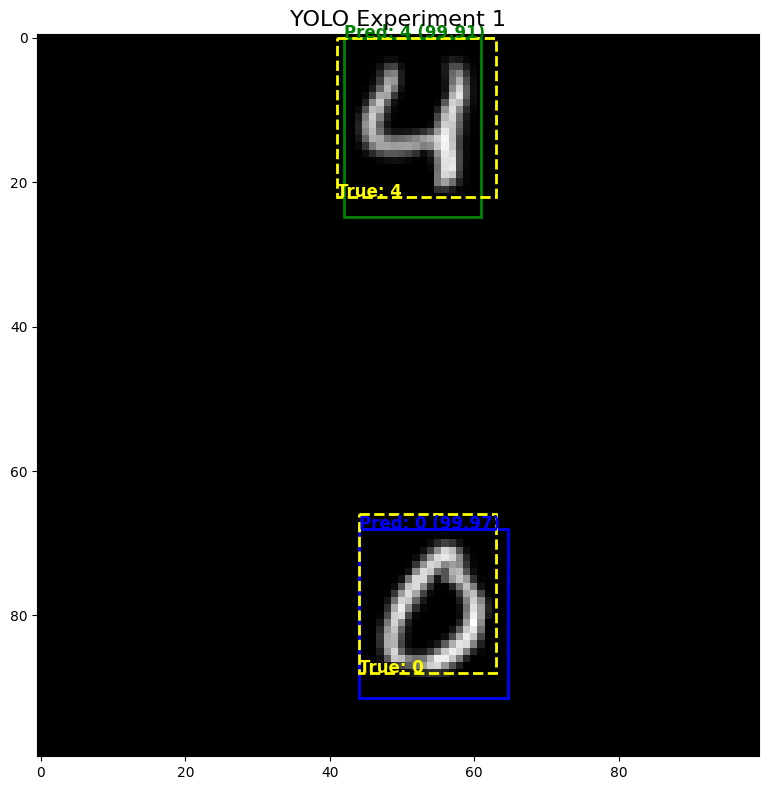

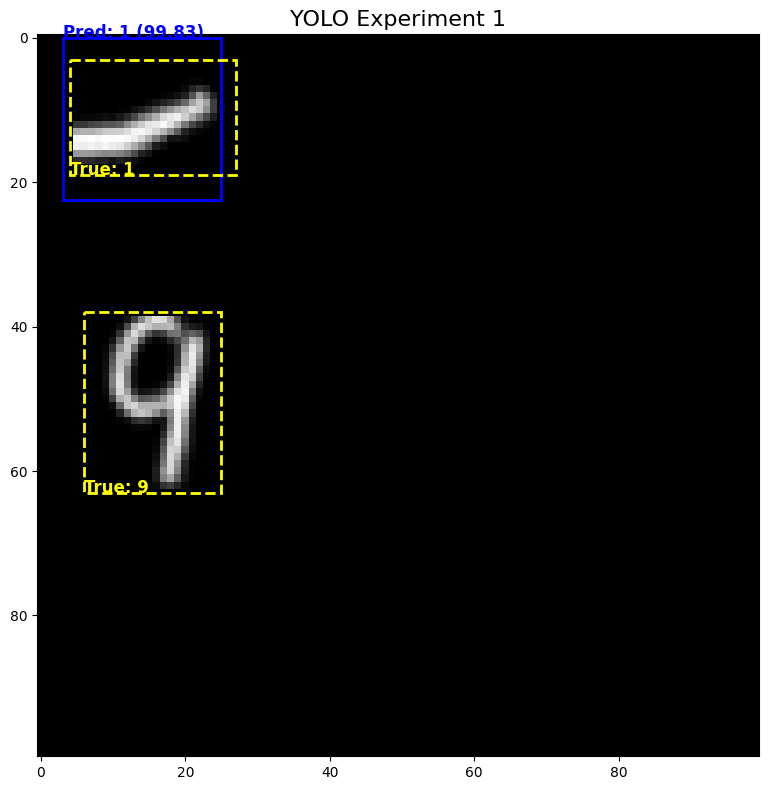

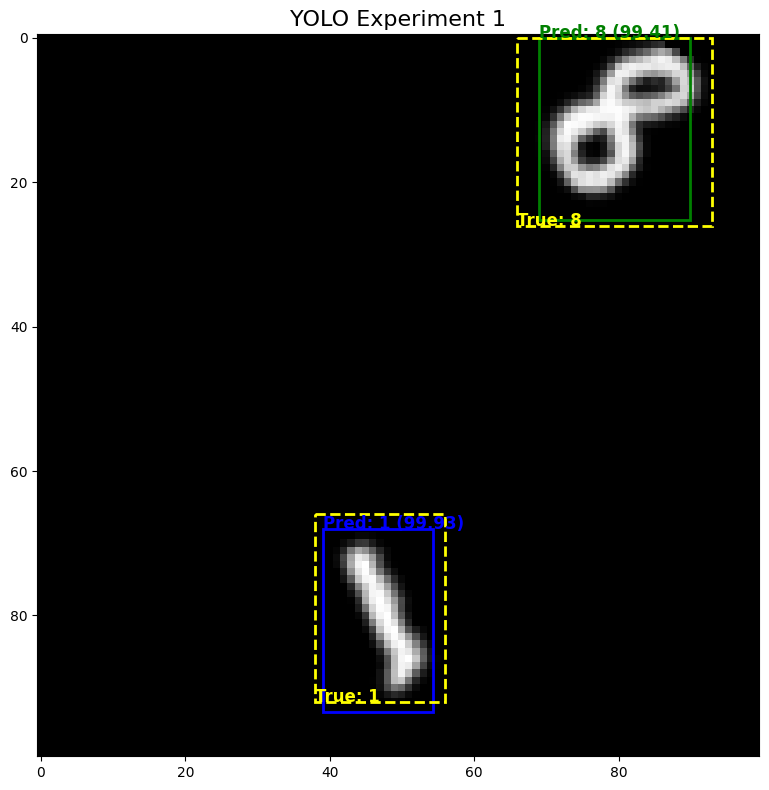

In [20]:
model_names = [(
    "YOLO Experiment 1", "yolo_experiment_1_digits_2_19_0.16.keras"
)]

evaluation_utils.visualize_model_predictions(
    model_names=model_names, num_of_digits=2, num_of_samples=3)

* Visually these bounding boxes looks great! 
* And the interpretation of these loss numbers is also promising,
    - The model predicts the bbox center within `1.45` pixels.
    - The model predicts the bbox size within `2 - 3` pixels.
    - The model is `88%` sure of the class.
    - The model is `97.4%` sure when there is an object.
    - The model is `94.3%` sure when there is no object.

* Our next experiment would be to see if we can reduce the class loss, and up the confidence score.


### YOLO Experiment 2

In [5]:
checkpoint_filepath = '../models/yolo_experiment_2_digits_2_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)

lambdas = {'bbox': 1.0, "bbox_coords": 1.0, "bbox_size": 1.0, 'class': 2.0,
           'obj': 1.0, 'obj_less': 1.0}

model = training_utils.get_fresh_base_model(batch_size=batch_size)
custom_model = yolo_object_detection_model.YoloObjectDetectionModel(
    model, lambdas=lambdas)

custom_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, clipnorm=1.0))

custom_model.build(input_shape=(None, 100, 100, 1))
# Fit the model
epochs = 20

# commenting out to avoid accidental fits and overwrites.
history = custom_model.fit(
    processed_dataset_2,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20


I0000 00:00:1762715436.032371    7867 service.cc:152] XLA service 0x7ff784001870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762715436.032419    7867 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-11-09 11:10:36.183521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762715437.030143    7867 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-09 11:10:38.136413: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[32,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,50,50]{3,2,1,0} %bitcast.10910, f32[8,8,3,3]{3,2,1,0} %bitcast.8393, f32[8]{0} %bitcast.11004), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

   3/1875 ━━━━━━━━━━━━━━━━━━━━ 59s 32ms/step - bbox_coordinate_loss: 0.0634 - bbox_size_loss: 0.0366 - class_loss: 2.3017 - loss: 6.1000 - obj_less_loss: 0.6907 - obj_loss: 0.7058   

I0000 00:00:1762715442.198587    7867 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - bbox_coordinate_loss: 0.0303 - bbox_size_loss: 0.0101 - class_loss: 1.2559 - loss: 2.8349 - obj_less_loss: 0.1987 - obj_loss: 0.0841
Epoch 1: loss improved from inf to 1.68652, saving model to ../models/yolo_experiment_2_digits_2_01_1.69.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 252s 126ms/step - bbox_coordinate_loss: 0.0303 - bbox_size_loss: 0.0101 - class_loss: 1.2556 - loss: 2.8343 - obj_less_loss: 0.1987 - obj_loss: 0.0841
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - bbox_coordinate_loss: 0.0085 - bbox_size_loss: 0.0011 - class_loss: 0.2869 - loss: 0.6870 - obj_less_loss: 0.0720 - obj_loss: 0.0316
Epoch 2: loss improved from 1.68652 to 0.62261, saving model to ../models/yolo_experiment_2_digits_2_02_0.62.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 234s 122ms/step - bbox_coordinate_loss: 0.0085 - bbox_size_loss: 0.0011 - class_loss: 0.2869 - loss: 0.6870 - obj_less_loss: 0.0720 - obj_loss: 0.0316
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━

* The model took ~80 mins finish 20 epochs. 
* Loss summary
```bash
- bbox_coordinate_loss: 0.0045 
- bbox_size_loss: 3.5014e-04 
- class_loss: 0.0794 
- loss: 0.2458 
- File : yolo_experiment_2_digits_2_20_0.25.keras
```
* There is a slight increase in all the losses but a significant improvement in class loss. Unfortunately overall loss went up.
* For now I think its safe to select the model from previous experiment as the final model for 2 digit recognition and use that as baseline for training more advanced models. 

## Object Detection With 3 Digits

### Initialize Data Generation Pipeline

In [9]:
# create a generator for 3 digits
data_gen_3_digits = graph_compatible_data_generator.create_data_generator(3)

processed_dataset_3 = raw_dataset.map(data_gen_3_digits).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

### Experiment 1
* In this experiment, we'll use the default params to train the model from `YOLO Experiment 1`, using the 3 digit training dataset. 

In [10]:
checkpoint_filepath = '../models/yolo_experiment_1_digits_3_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)

# lambdas = {'bbox': 1.0, "bbox_coords": 1.0, "bbox_size": 1.0, 'class': 1.0,
#            'obj': 1.0, 'obj_less': 1.0}

custom_objects = {
    "YoloObjectDetectionModel": yolo_object_detection_model.YoloObjectDetectionModel}


model = tf.keras.models.load_model(
    Path(models_dir, "yolo_experiment_1_digits_2_19_0.16.keras"), custom_objects=custom_objects)


# model = training_utils.get_fresh_base_model(batch_size=batch_size)
# custom_model = yolo_object_detection_model.YoloObjectDetectionModel(
#     model, lambdas=lambdas)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, clipnorm=1.0))

model.build(input_shape=(None, 100, 100, 1))
# Fit the model
epochs = 20

# commenting out to avoid accidental fits and overwrites.
history = model.fit(
    processed_dataset_3,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20


I0000 00:00:1762798971.869582  121287 service.cc:152] XLA service 0x7fc064002460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762798971.869634  121287 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-11-10 10:22:52.042873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762798972.918387  121287 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-10 10:22:53.951537: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[32,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,50,50]{3,2,1,0} %bitcast.10877, f32[8,8,3,3]{3,2,1,0} %bitcast.8371, f32[8]{0} %bitcast.10971), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

   3/1875 ━━━━━━━━━━━━━━━━━━━━ 1:01 33ms/step - bbox_coordinate_loss: 0.0034 - bbox_size_loss: 3.3006e-04 - class_loss: 0.0752 - loss: 0.1991 - obj_less_loss: 0.0719 - obj_loss: 0.0483  

I0000 00:00:1762798977.991787  121287 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - bbox_coordinate_loss: 0.0032 - bbox_size_loss: 3.1759e-04 - class_loss: 0.0779 - loss: 0.1779 - obj_less_loss: 0.0654 - obj_loss: 0.0311
Epoch 1: loss improved from inf to 0.17686, saving model to ../models/yolo_experiment_1_digits_3_01_0.18.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 263s 132ms/step - bbox_coordinate_loss: 0.0032 - bbox_size_loss: 3.1759e-04 - class_loss: 0.0779 - loss: 0.1779 - obj_less_loss: 0.0654 - obj_loss: 0.0311
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - bbox_coordinate_loss: 0.0030 - bbox_size_loss: 3.0995e-04 - class_loss: 0.0764 - loss: 0.1708 - obj_less_loss: 0.0617 - obj_loss: 0.0294
Epoch 2: loss improved from 0.17686 to 0.16893, saving model to ../models/yolo_experiment_1_digits_3_02_0.17.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 248s 130ms/step - bbox_coordinate_loss: 0.0030 - bbox_size_loss: 3.0995e-04 - class_loss: 0.0764 - loss: 0.1708 - obj_less_loss: 0.0617 - obj_loss: 0.0294
Epoch 3/20
1875/1875 ━━

* The model took ~85 mins finish 20 epochs. 
* Loss summary
```bash
- bbox_coordinate_loss: 0.0024
- bbox_size_loss: 3.1248e-04 
- class_loss: 0.0660 
- loss: 0.1368 
- File : yolo_experiment_1_digits_3_20_0.14.keras
```
* Lets test this visually and see if the model performance is acceptable. 

2025-11-10 13:06:39.499513: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[32,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,50,50]{3,2,1,0} %bitcast.330, f32[8,8,3,3]{3,2,1,0} %bitcast.337, f32[8]{0} %bitcast.339), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="yolo_object_detection_model_1_1/functional_2_1/conv2d_11_1/convolution" source_file="/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-11-10 13:06:39.536049: I external/local_xla/xla/se

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


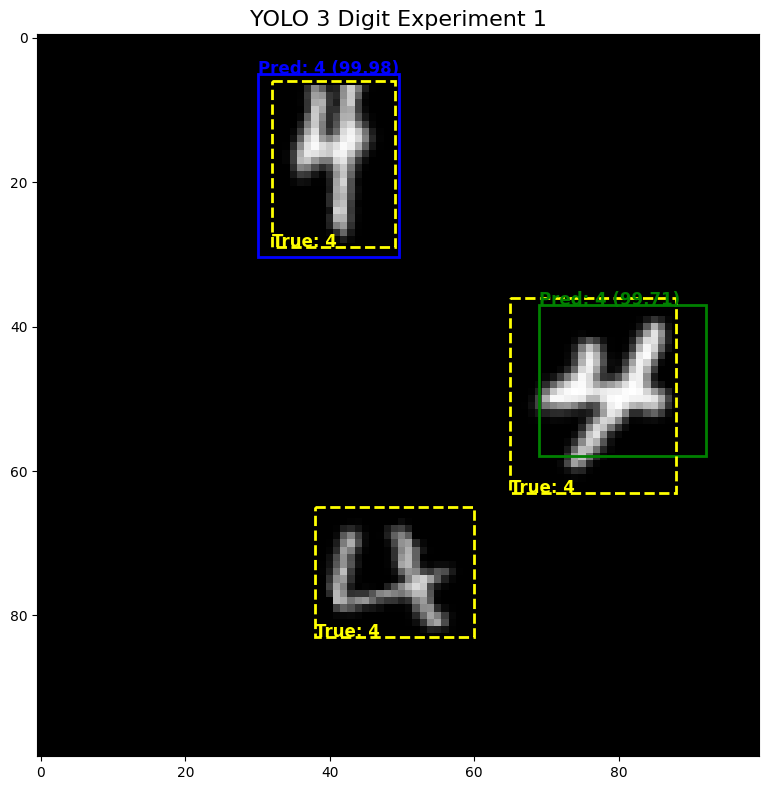

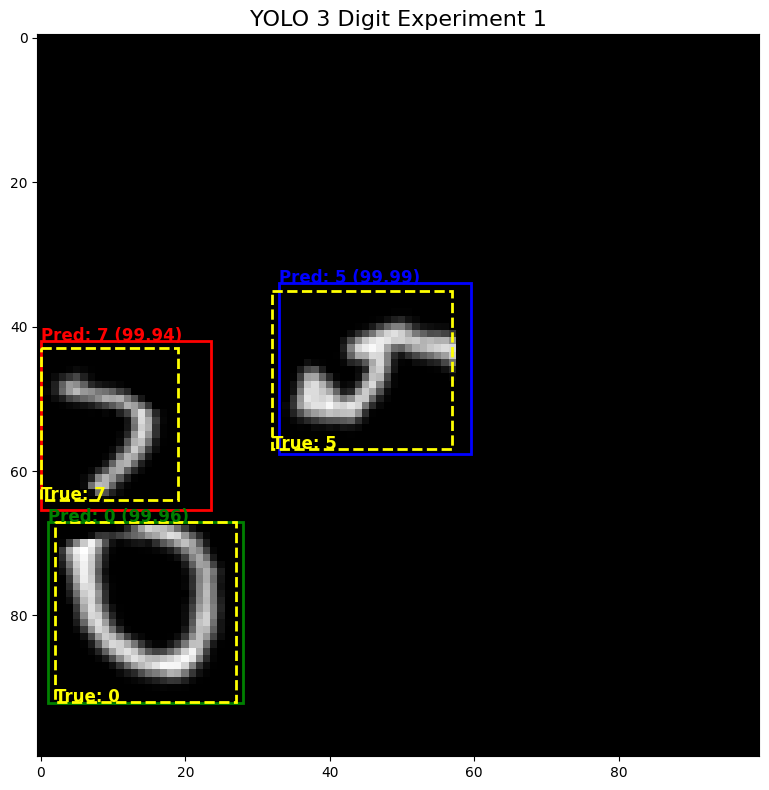

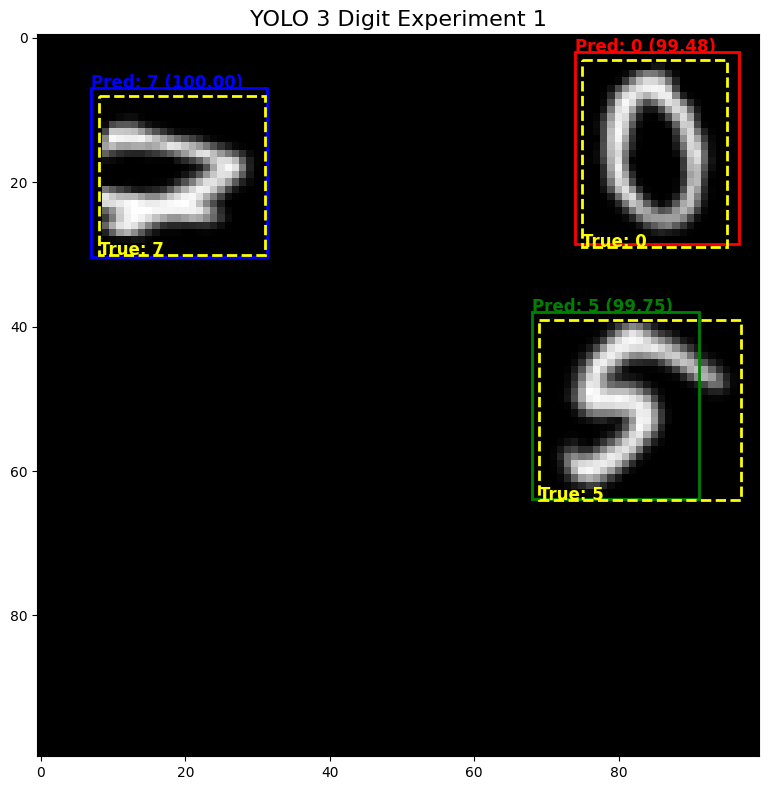

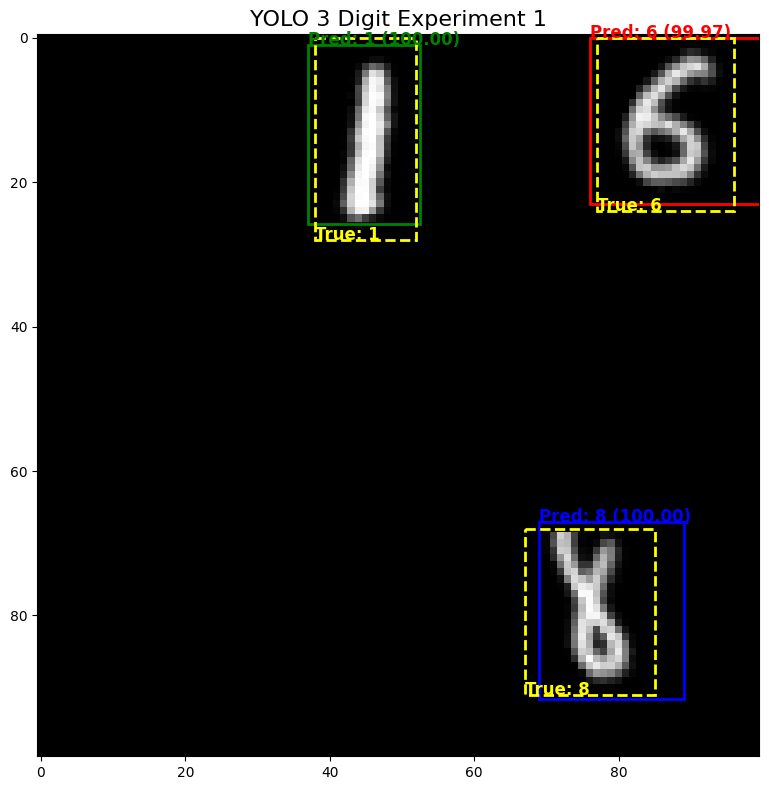

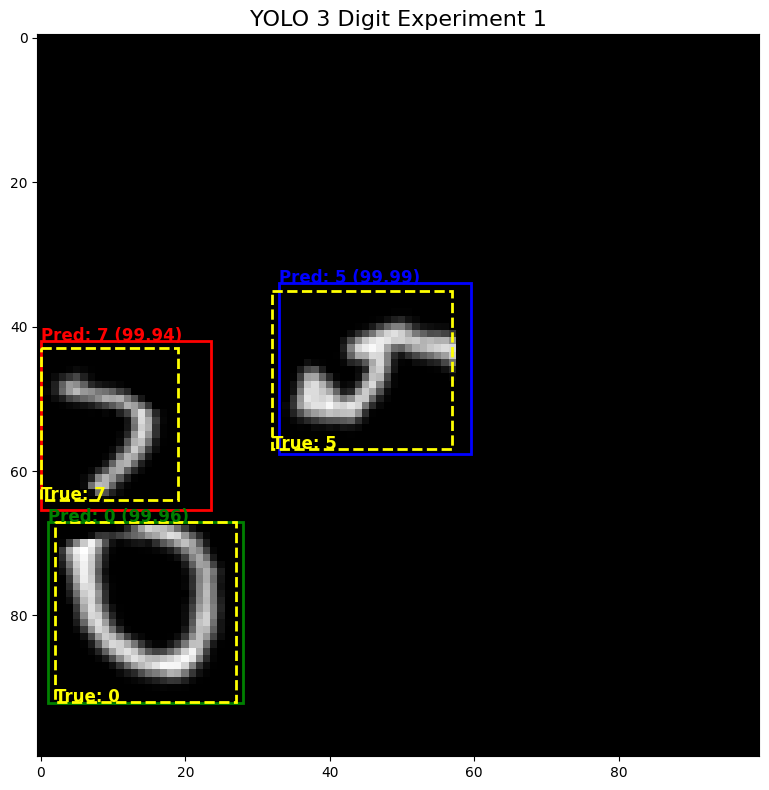

In [11]:
model_names=[(
    "YOLO 3 Digit Experiment 1", "yolo_experiment_1_digits_3_20_0.14.keras"
)]

evaluation_utils.visualize_model_predictions(
    model_names=model_names, num_of_digits=3, num_of_samples=5)

* So we are getting descent results with these loss functions, randomly we see a scenario where the model doesn't find a bounding box for one digit but for now lets train it to recognize 4 digits and continue with curriculum learning. 

## Object Detection with 4 digits

In [12]:
data_gen_4_digits = graph_compatible_data_generator.create_data_generator(4)

processed_dataset_4 = raw_dataset.map(data_gen_4_digits).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
checkpoint_filepath = '../models/yolo_experiment_1_digits_4_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)

# lambdas = {'bbox': 1.0, "bbox_coords": 1.0, "bbox_size": 1.0, 'class': 1.0,
#            'obj': 1.0, 'obj_less': 1.0}

custom_objects = {
    "YoloObjectDetectionModel": yolo_object_detection_model.YoloObjectDetectionModel}


model = tf.keras.models.load_model(
    Path(models_dir, "yolo_experiment_1_digits_3_20_0.14.keras"), custom_objects=custom_objects)


# model = training_utils.get_fresh_base_model(batch_size=batch_size)
# custom_model = yolo_object_detection_model.YoloObjectDetectionModel(
#     model, lambdas=lambdas)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, clipnorm=1.0))

model.build(input_shape=(None, 100, 100, 1))
# Fit the model
epochs = 20

# commenting out to avoid accidental fits and overwrites.
history = model.fit(
    processed_dataset_4,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - bbox_coordinate_loss: 0.0025 - bbox_size_loss: 3.0915e-04 - class_loss: 0.0641 - loss: 0.1495 - obj_less_loss: 0.0545 - obj_loss: 0.0281
Epoch 1: loss improved from inf to 0.14941, saving model to ../models/yolo_experiment_1_digits_4_01_0.15.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 284s 144ms/step - bbox_coordinate_loss: 0.0025 - bbox_size_loss: 3.0915e-04 - class_loss: 0.0641 - loss: 0.1495 - obj_less_loss: 0.0545 - obj_loss: 0.0281
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - bbox_coordinate_loss: 0.0024 - bbox_size_loss: 3.0875e-04 - class_loss: 0.0651 - loss: 0.1471 - obj_less_loss: 0.0524 - obj_loss: 0.0269
Epoch 2: loss improved from 0.14941 to 0.14675, saving model to ../models/yolo_experiment_1_digits_4_02_0.15.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 266s 140ms/step - bbox_coordinate_loss: 0.0024 - bbox_size_loss: 3.0875e-04 - class_loss: 0.0651 - loss: 0.1471 - obj_less_loss: 0.0524 - obj_loss: 0.0269
Epoch 3/20
1

* Loss summary
```bash
- bbox_coordinate_loss: 0.0021
- bbox_size_loss: 2.9064e-04 
- class_loss: 0.0596 
- loss: 0.1333 
- File : yolo_experiment_1_digits_4_18_0.13.keras
```
* Overall the loss has slightly decresed than the previous models, which is great sign.  
* At the end of next fit we'll test against the test data to make sure we don't have problem of over fittin. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


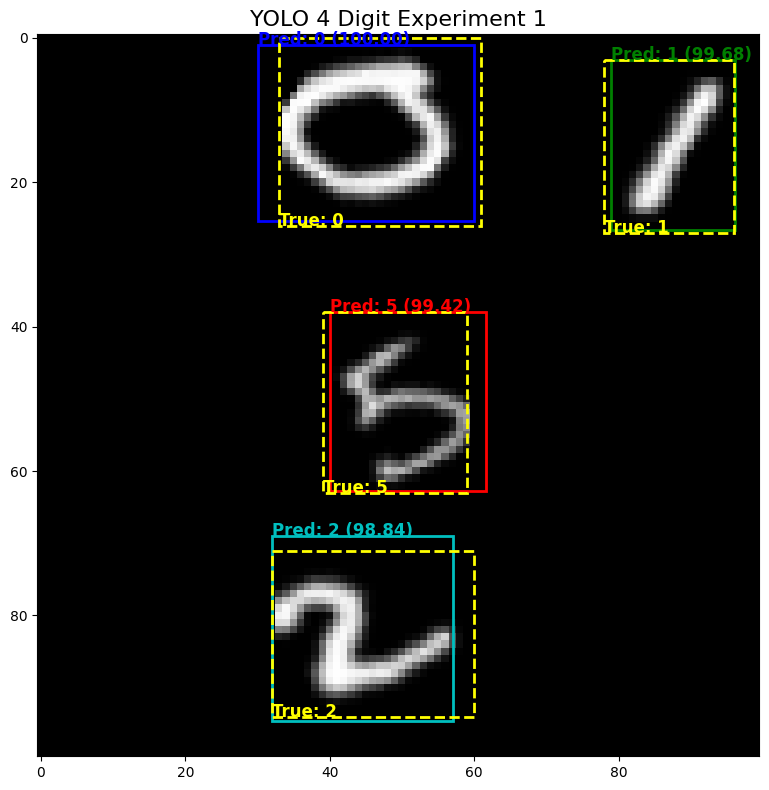

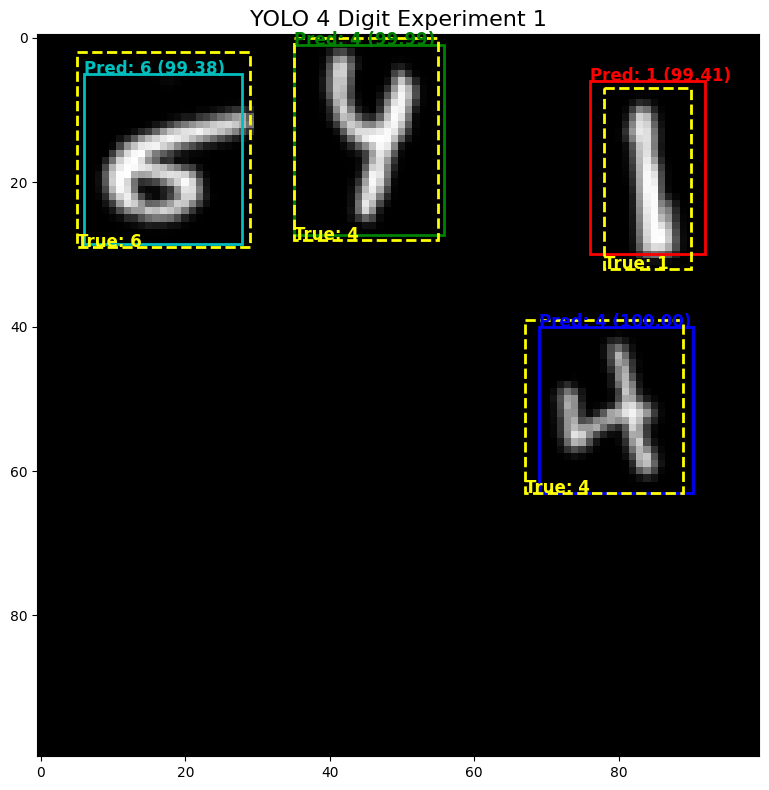

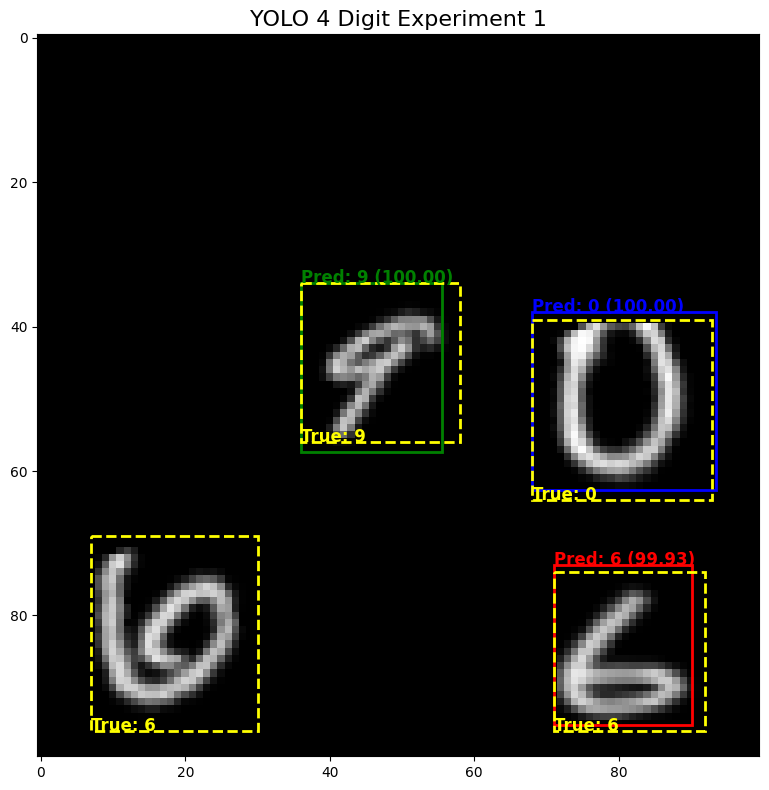

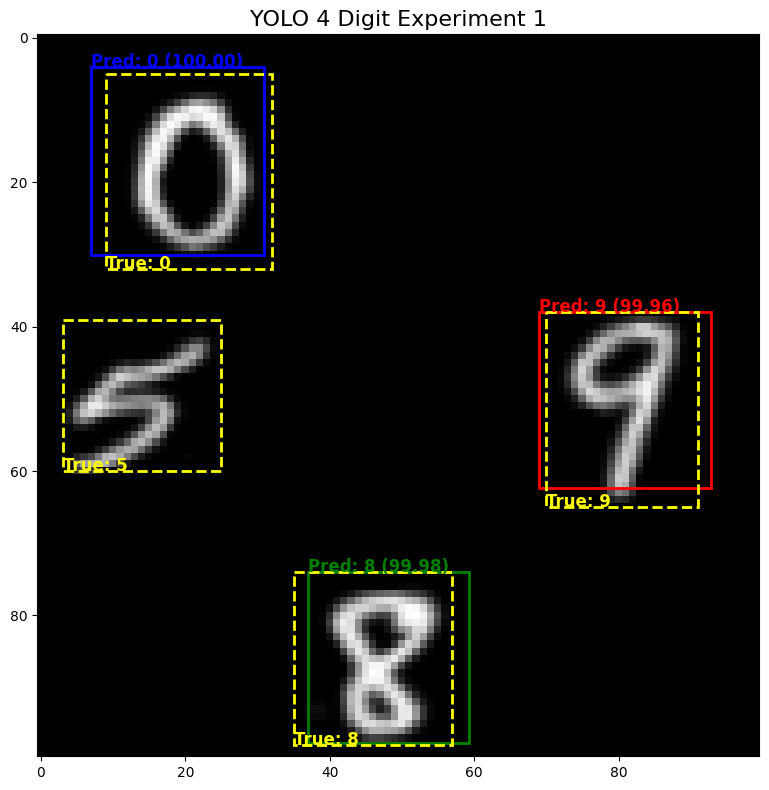

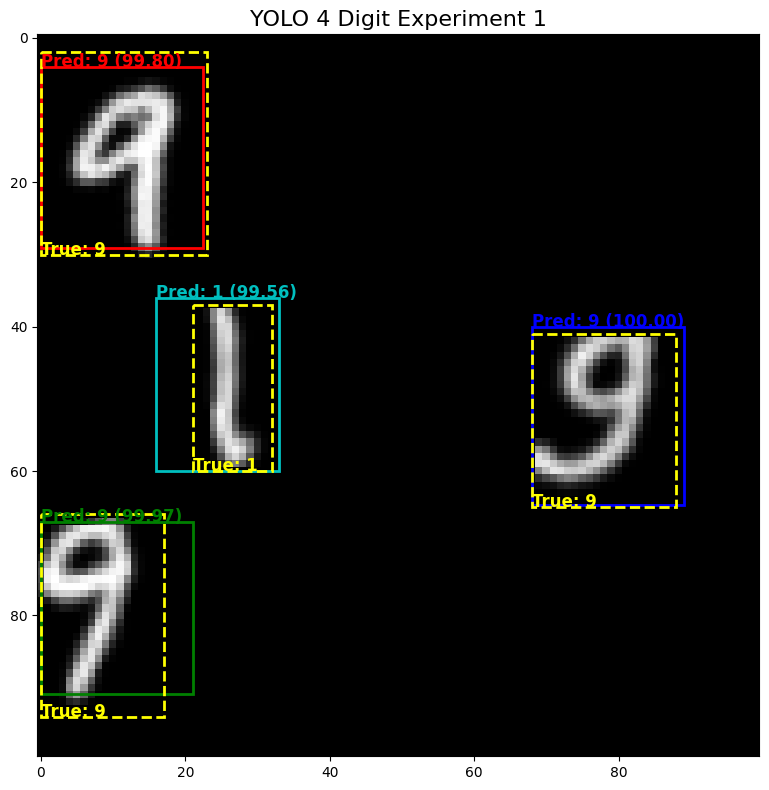

In [5]:
model_names=[(
    "YOLO 4 Digit Experiment 1", "yolo_experiment_1_digits_4_18_0.13.keras"
)]

evaluation_utils.visualize_model_predictions(
    model_names=model_names, num_of_digits=4, num_of_samples=5)

* So the model is pretty descent at predicting bounding boxes for 4 digits. There are still some occational random digits that doesn't get detected, but based on the numbers and visual confirmation its a acceptable count for now. 
* Lets see if the model can detect 5 digits, without any specialized training. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


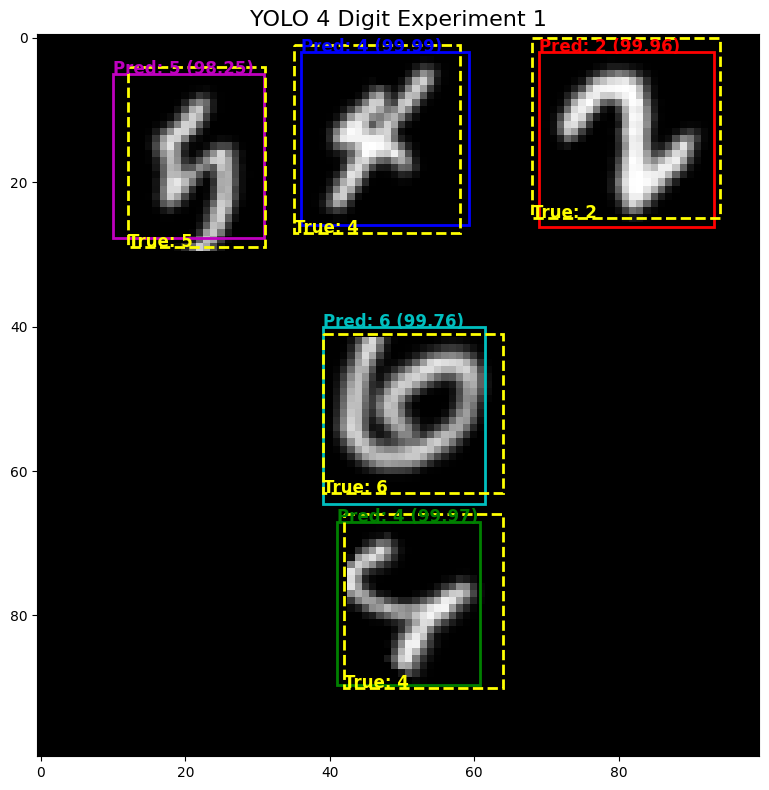

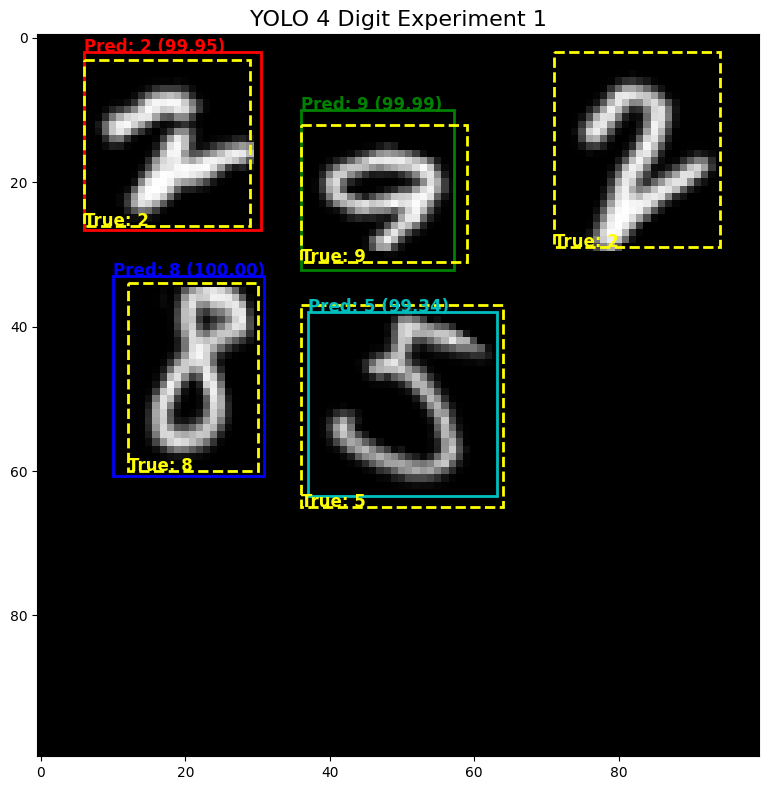

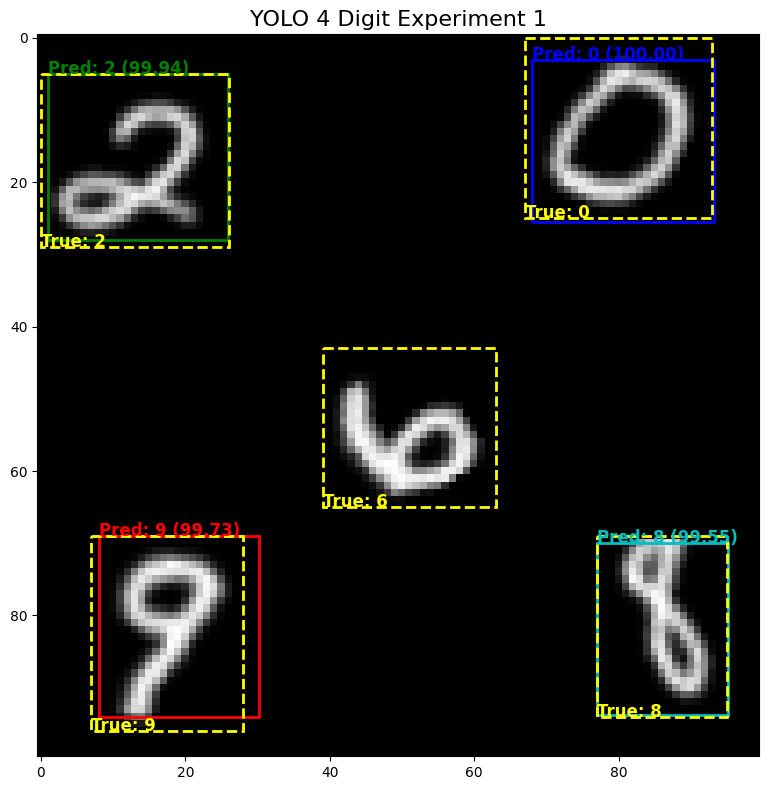

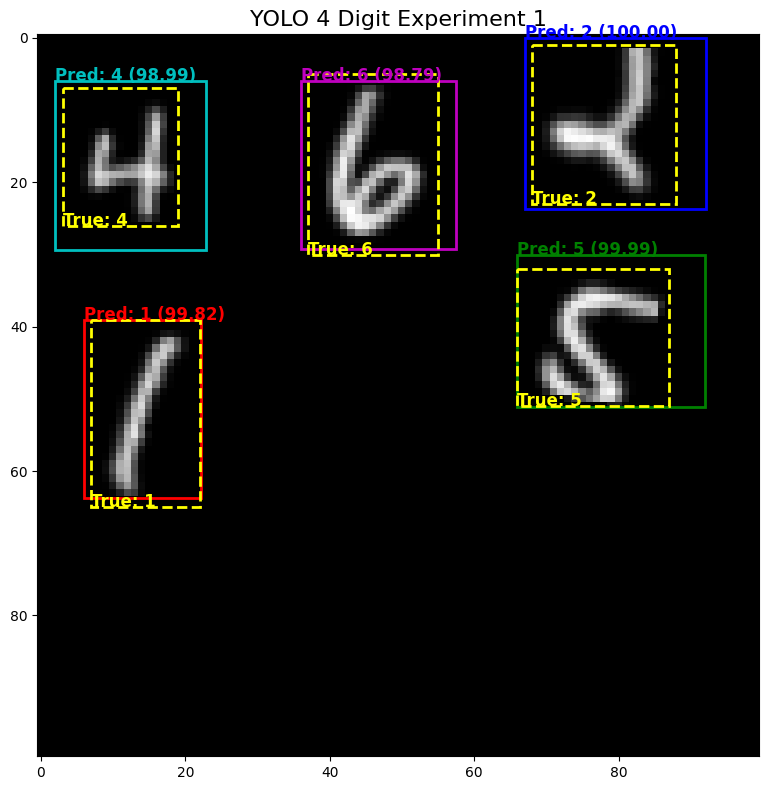

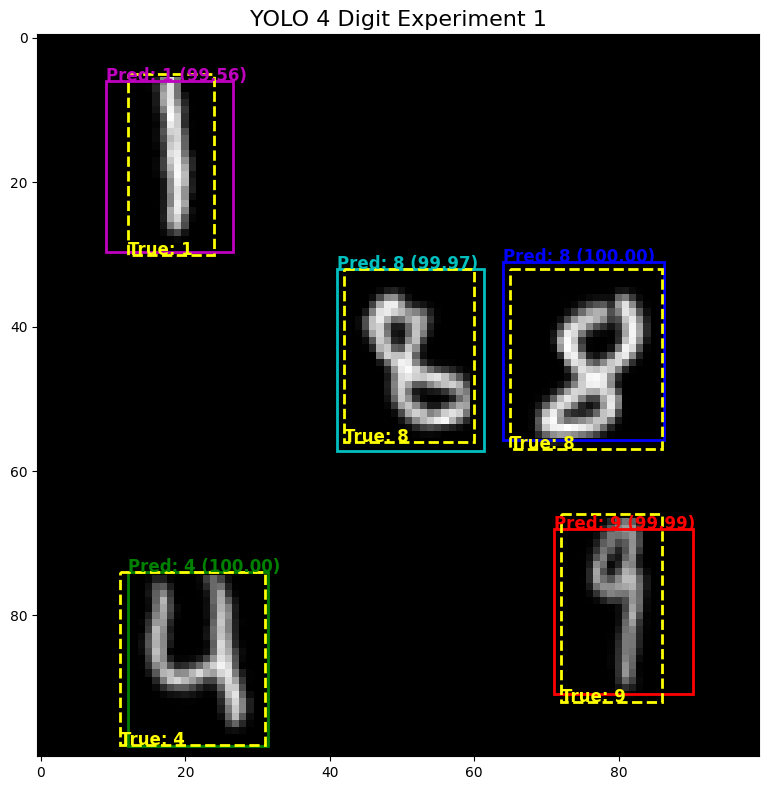

In [6]:
model_names=[(
    "YOLO 4 Digit Experiment 1", "yolo_experiment_1_digits_4_18_0.13.keras"
)]

evaluation_utils.visualize_model_predictions(
    model_names=model_names, num_of_digits=5, num_of_samples=5)

* The model did surprisingly well, without any curriculum training for 5 digits!
* But still we'll train against 5 digits and use that as final model if the loss numbers support.

## Object Detection with 5 Digits

In [9]:
data_gen_5_digits = graph_compatible_data_generator.create_data_generator(5)

processed_dataset_5 = raw_dataset.map(data_gen_5_digits).batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)

In [10]:
checkpoint_filepath = '../models/yolo_experiment_1_digits_5_{epoch:02d}_{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1,
)

# lambdas = {'bbox': 1.0, "bbox_coords": 1.0, "bbox_size": 1.0, 'class': 1.0,
#            'obj': 1.0, 'obj_less': 1.0}

custom_objects = {
    "YoloObjectDetectionModel": yolo_object_detection_model.YoloObjectDetectionModel}


model = tf.keras.models.load_model(
    Path(models_dir, "yolo_experiment_1_digits_4_18_0.13.keras"), custom_objects=custom_objects)


# model = training_utils.get_fresh_base_model(batch_size=batch_size)
# custom_model = yolo_object_detection_model.YoloObjectDetectionModel(
#     model, lambdas=lambdas)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, clipnorm=1.0))

model.build(input_shape=(None, 100, 100, 1))
# Fit the model
epochs = 20

# commenting out to avoid accidental fits and overwrites.
history = model.fit(
    processed_dataset_5,
    epochs=epochs,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20


2025-11-10 16:18:07.083237: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.29 = (f32[32,8,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,8,50,50]{3,2,1,0} %bitcast.10877, f32[8,8,3,3]{3,2,1,0} %bitcast.8371, f32[8]{0} %bitcast.10971), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_2_1/conv2d_11_1/convolution" source_file="/home/gaurangdave/workspace/mnist_object_detection/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-11-10 16:18:07.119949: I external/local_xla/xla/service/gpu/autotuning/conv_a

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - bbox_coordinate_loss: 0.0021 - bbox_size_loss: 2.8432e-04 - class_loss: 0.0584 - loss: 0.1434 - obj_less_loss: 0.0538 - obj_loss: 0.0288
Epoch 1: loss improved from inf to 0.14278, saving model to ../models/yolo_experiment_1_digits_5_01_0.14.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 300s 152ms/step - bbox_coordinate_loss: 0.0021 - bbox_size_loss: 2.8432e-04 - class_loss: 0.0584 - loss: 0.1434 - obj_less_loss: 0.0538 - obj_loss: 0.0288
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - bbox_coordinate_loss: 0.0021 - bbox_size_loss: 2.8493e-04 - class_loss: 0.0576 - loss: 0.1405 - obj_less_loss: 0.0524 - obj_loss: 0.0281
Epoch 2: loss improved from 0.14278 to 0.14193, saving model to ../models/yolo_experiment_1_digits_5_02_0.14.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 288s 151ms/step - bbox_coordinate_loss: 0.0021 - bbox_size_loss: 2.8493e-04 - class_loss: 0.0576 - loss: 0.1405 - obj_less_loss: 0.0524 - obj_loss: 0.0281
Epoch 3/20
1875/1875 ━━

* Loss summary
```bash
- bbox_coordinate_loss: 0.0018
- bbox_size_loss: 2.9064e-04 
- class_loss: 0.0596 
- loss: 0.1333 
- File : yolo_experiment_1_digits_4_18_0.13.keras
```
* So our final model is at par with the previous models, slight improvement but nothing significant. 
* I think we can use this model for production app, but before that lets run some visual tests

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


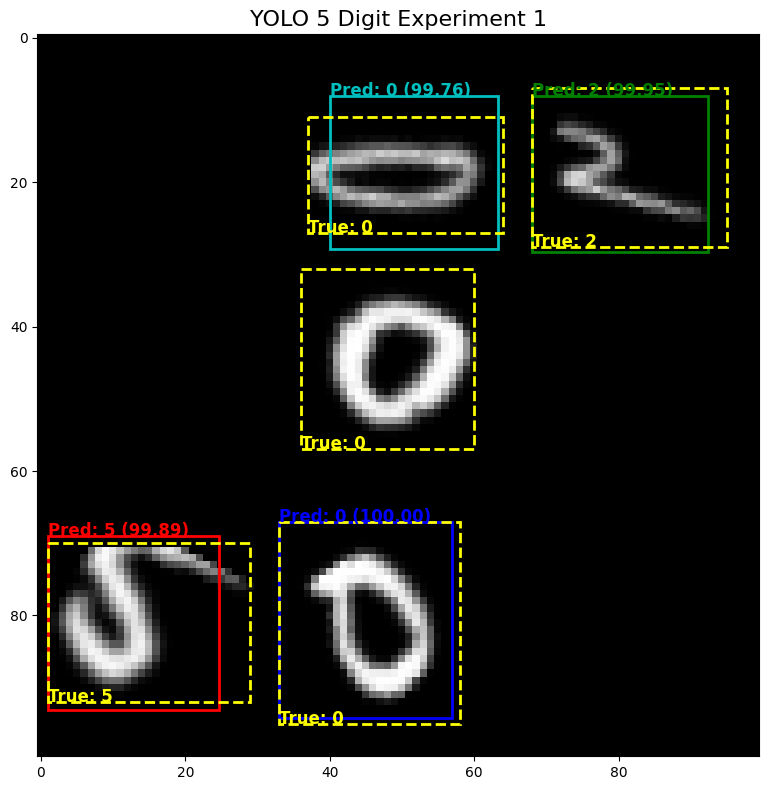

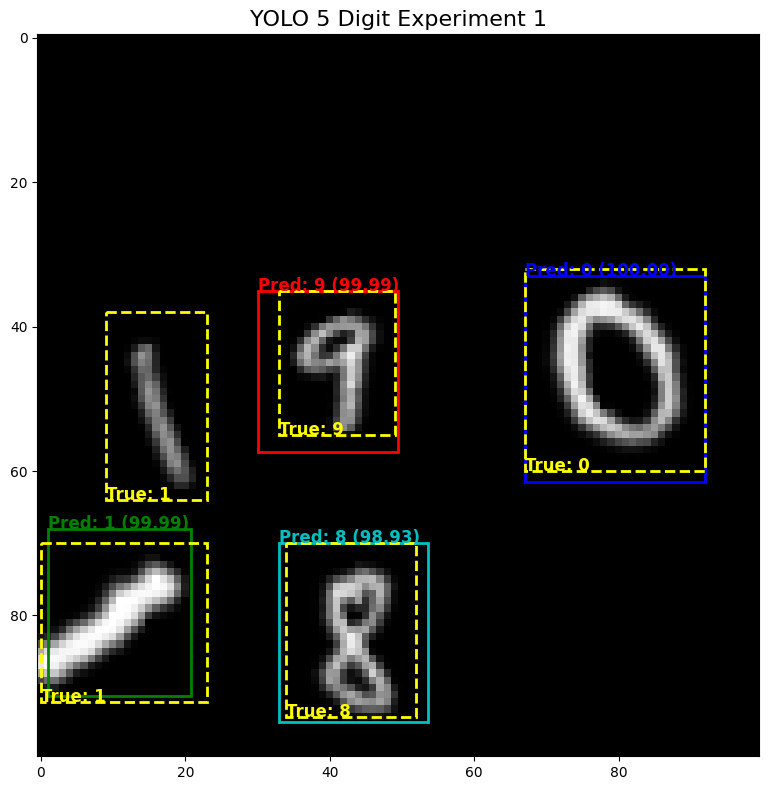

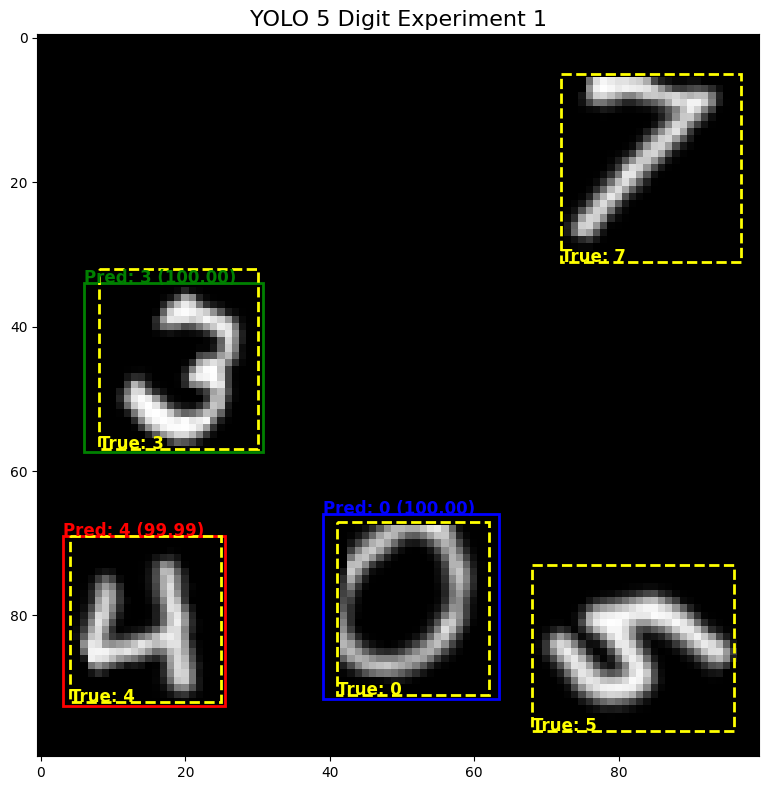

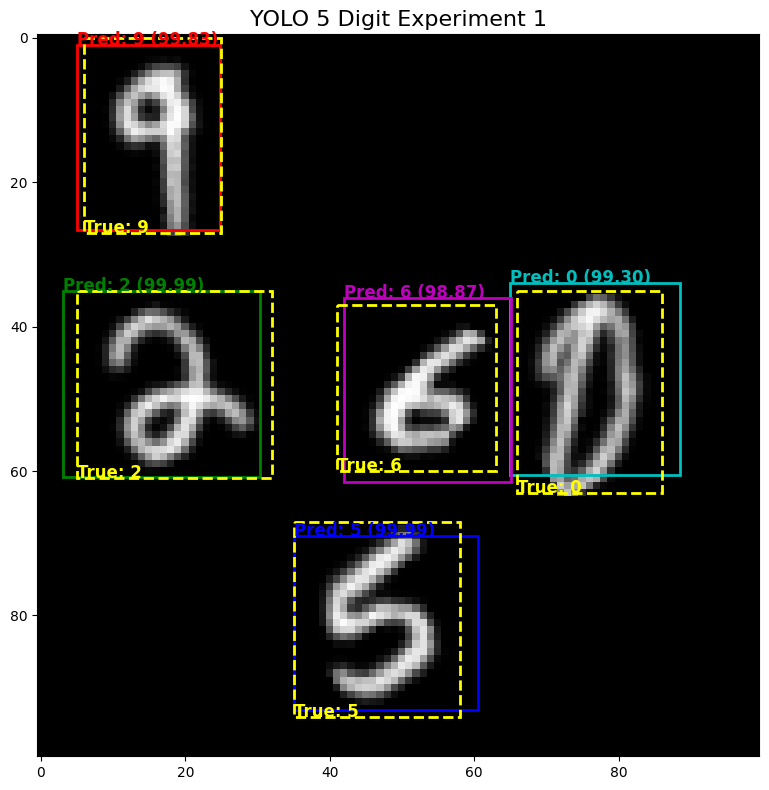

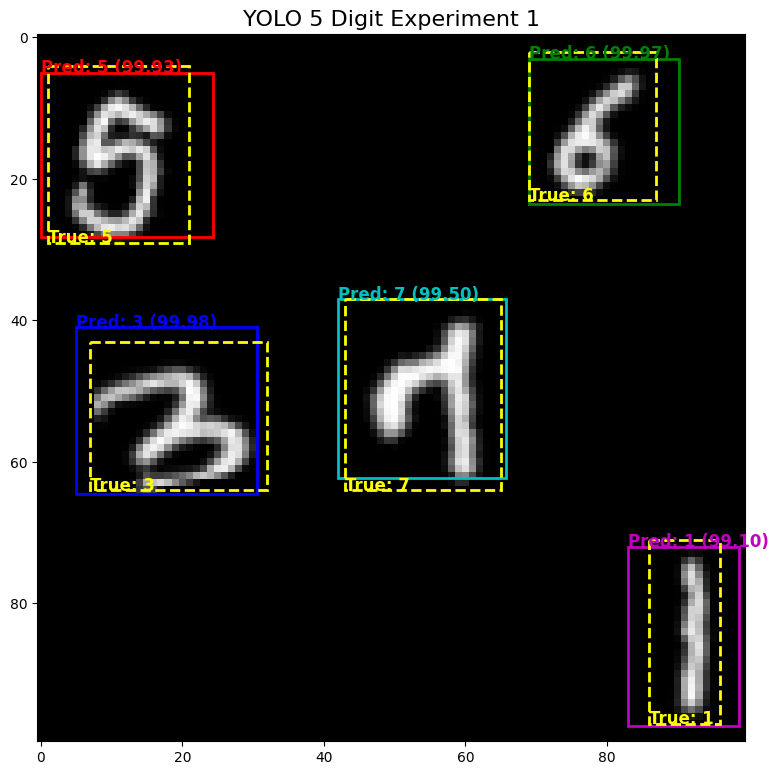

In [5]:


model_names=[(
    "YOLO 5 Digit Experiment 1", "yolo_experiment_1_digits_5_20_0.13.keras"
)]

evaluation_utils.visualize_model_predictions(
    model_names=model_names, num_of_digits=5, num_of_samples=5)

## Final Models
* So below are the best models that we trained for different number of digits, i.e our graduates from different curriculum
```bash
Model Trained on 5 digits : yolo_experiment_1_digits_5_20_0.13.keras
Model Trained on 4 digits : yolo_experiment_1_digits_4_18_0.13.keras
Model Trained on 3 digits : yolo_experiment_1_digits_3_20_0.14.keras
Model Trained on 2 digits : yolo_experiment_1_digits_2_19_0.16.keras
```
* Next step is to evaluate these models, against unseen test data and we'll see which models performs the best. 
* We'll do that in a seperate notebook

